# Exploratory Data Analysis in Python

In this course I'm going to share with you my techniques and thought processes for exploratory data analysis.  I'll demonstrate everything with analysis of a real data set.  It is important to emphasize that there isn't a single right way to do exploratory data analysis.  The way you explore your data depends on the questions you're trying to answer and the data itself.  As such, you shouldn't try to replicate this analysis exactly, rather let the data and your curiousity guide you.  

There are a few core libraries you want to become familiar with.  This includes:

* NumPy: provides the core array class for efficient storage and vectorized computation.
* Pandas: wraps NumPy arrays with a series and dataframe object providing lots of convenient methods.
* SciPy: a wide variety of scientific computation tools, including statistics, optimization and signal processing.
* Scikit-learn: a wide variety of machine learning methods, as well as data processing helpers.
* Matplotlib: The most full-featured Python plotting library.  Generates static images.
* Bokeh: A new plotting library.  Able to render interactive plots in notebooks.



In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import hdbscan

from collections import Counter
from bokeh.io import output_notebook, show
from bokeh.models import Range1d
from scipy.stats import gaussian_kde, anderson, skew, kurtosis, gamma, entropy
from itertools import zip_longest, count, cycle
from helpers import block_heatmap, scatter_with_hover, plot_histogram, counter_histogram, bar_color
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import MDS, TSNE
from statsmodels.distributions.empirical_distribution import ECDF
from ipywidgets import interact
from matplotlib.colors import ListedColormap

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 5)
output_notebook()

Loading BokehJS ...

## The dataset

This dataset is basically a table of samples with nuclear protein abundance data.  These samples are from either normal mice or mice with a condition similar to downs syndrome.  Some of these mice were given a drug called memantine, which they hypothesized could rescue cognitive function in affected mice.  There are 38 normal mice and 34 affected mice, and each mouse contributed 15 samples to the data set, for a total of 1080 samples.  The abundance ratio of 77 proteins are measured for each sample.
  
This dataset is available from [here](https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression).

In [2]:
df = pd.read_excel("Data_Cortex_Nuclear.xls", index_col=0)

df = df.fillna(df.mean())
df_numeric = df.filter(like="_N", axis=1)

## Generating additional summary statistics

Pandas dataframes has a handy method called describe.  Describe gives you a variety of summary statistics for each variable.  The summary statistics returned by this method are also a dataframe, so you can amend it easily to include other statistics.  We'll do exactly that, adding the variable's coefficient of variation.

The coefficient of variation is just the ratio of the standard deviation to the mean of the distribution.  Distributions with a large coefficient of variation are more likely to signal a change in the underlying data generation process, as opposed to random variation.

In [3]:
description = df.describe()
coef_variation = description.loc["std"] / description.loc["mean"]
description.loc["cova"] = coef_variation
description.sort_values(by="cova", axis=1)

,ERBB4_N,P3525_N,BAX_N,GFAP_N,pGSK3B_Tyr216_N,PSD95_N,ARC_N,pS6_N,pGSK3B_N,CDK5_N,...,Tau_N,pPKCG_N,pCAMKII_N,pP70S6_N,ITSN1_N,SOD1_N,BRAF_N,DYRK1A_N,pERK_N,AcetylH3K9_N
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.156478,0.291276,0.179307,0.120889,0.848767,2.235236,0.121521,0.121521,0.161211,0.292434,...,0.210489,1.706599,3.537109,0.394475,0.617102,0.542635,0.378519,0.425810,0.545904,0.216482
std,0.015071,0.030015,0.018826,0.013233,0.094311,0.254395,0.014276,0.014276,0.019308,0.037380,...,0.069010,0.578442,1.293368,0.155953,0.251290,0.280178,0.216087,0.249015,0.344829,0.185309
min,0.100217,0.207438,0.072326,0.086114,0.577397,1.206098,0.067254,0.067254,0.099976,0.181157,...,0.096233,0.598767,1.343998,0.131120,0.245359,0.217120,0.143894,0.145327,0.149155,0.052528
25%,0.146969,0.270059,0.168172,0.112765,0.793739,2.079338,0.110839,0.110839,0.149253,0.272594,...,0.167991,1.296830,2.479861,0.282131,0.473669,0.319712,0.264356,0.288163,0.337486,0.103571
50%,0.156371,0.290646,0.180745,0.120459,0.849858,2.242197,0.121626,0.121626,0.160212,0.293820,...,0.188630,1.664560,3.329624,0.378673,0.566365,0.446027,0.326730,0.366540,0.444223,0.150417
75%,0.165421,0.311602,0.191577,0.127724,0.916173,2.420226,0.131955,0.131955,0.171739,0.312484,...,0.233943,2.112973,4.480652,0.480704,0.697500,0.695318,0.412716,0.487574,0.663173,0.269653
max,0.208698,0.443735,0.241141,0.213621,1.204598,2.877873,0.158748,0.158748,0.253210,0.817402,...,0.602768,3.381976,7.464070,1.129171,2.602662,1.872899,2.133416,2.516367,3.566685,1.459387
cova,0.096313,0.103047,0.104995,0.109467,0.111116,0.113811,0.117482,0.117482,0.119768,0.127823,...,0.327855,0.338945,0.365657,0.395343,0.407210,0.516329,0.570875,0.584803,0.631665,0.856000


This data set contains 15 samples for each individual mouse.  Let's update the data frame to include which mouse each sample came from in an easily usable format.

In [4]:
mouse_id = pd.Series([i.split("_")[0] for i in df.index], index=df.index, name='mouse_id')
df = df.join(mouse_id)

## Normalization

One important initial step before any real analysis is performed is to normalize the data.  This is necessary in order to prevent variables with large values from having an undue influence on results. There are a few different methods of normalizing your data:
 
* The most common method is to divide a dimension’s values by the largest value it contains.  This method is easy to interpret, and it is robust to outliers when the coefficient of variation on a dimension is low.  
* Another very common method is to subtract the dimension’s mean and divide by its standard deviation, a process sometimes called standardizing.  This method provides more information about the relative similarity of values when the coefficient of variation on a dimension is high.  It performs poorly on dimensions with a low coefficient of variation and large outliers.
* An underutilized option is to use the cumulative distribution function of the dimension’s empirical distribution to get a percentile ranking.  This method works well in most cases and is robust to outliers.  Its usefulness degrades somewhat when a dimension’s coefficient of variation gets very small.
 
The normalization method you use depends on your data and the aspects of it that you want to highlight.  You can use a different normalization method for each dimension of your data, though I don’t advise you do this unless absolutely necessary.  In general my preference is for the empirical distribution method.


In [5]:
minmax_normalized_df = pd.DataFrame(MinMaxScaler().fit_transform(df_numeric),
                                    columns=df_numeric.columns, index=df_numeric.index)

standardized_df = pd.DataFrame(StandardScaler().fit_transform(df_numeric), columns=df_numeric.columns,
                               index=df_numeric.index)

ecdf_normalized_df = df_numeric.apply(lambda c: pd.Series(ECDF(c)(c), index=c.index))

## Visualizing distributions

The best way to understand a data set is to look at the distribution of its properties.  The best way to examine a distribution is by looking at its density function.  The graph of the density function is a complete visual description of the distribution.  Unfortunately, the density function of real data is unknown.

Histograms naturally approximate the density function for discrete data.  In the case of continuous data, histograms are extremely sensitive to the number of bins and their edges.  They can still work well, but it requires a lot of data and usually some hand tuning.

An alternative technique to histograms is to use a density estimator.  Density estimators work well with continuous variables, and they produce reasonable results without a lot of data.  Density estimation is basically a form of smoothing or interpolation between observed data points.  The density estimator I prefer is called a gaussian kernel density estimator.  This is basically a linear interpolater where the distance between points is transformed by a function called the kernel.  It has a single parameter, the width of the kernel, which can be reasonably estimated from the data.

The best option is to take advantage of both histograms and density estimators.  All my plots in this presentation will follow this convention.  I also include the cumulative distribution function (CDF).  This lets you see the relative proportion of the distribution at or below a given value.

## Exploring Data

My strategy for exploring data is to look for things that are out of the ordinary.  If you had a data set that was just uncorrelated gaussian random variables, you couldn't learn anything from it, it would literally be white noise.  The majority of the information content in most data set is are its variations from normality.

The distribution of the coefficient of variation tells you about the relative variability of that data.  High coefficients of variation for a variable indicate a likely candidate for experimental effect.

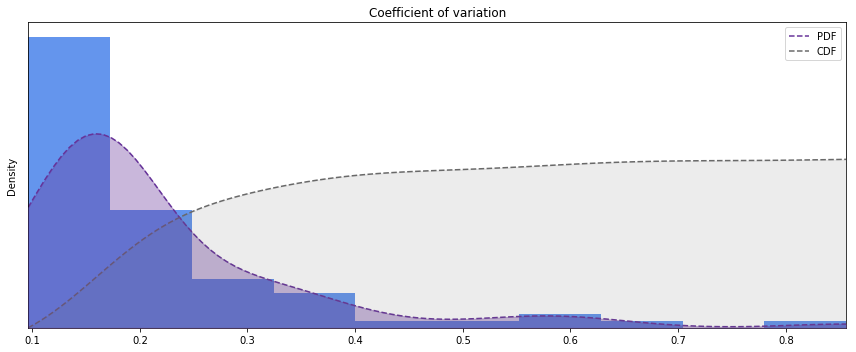

In [6]:
plot_histogram(description.loc["cova"], title="Coefficient of variation");

Based on this distribution, 0.3 appears to be a good cut-off value.  Let's go ahead and take a look at those proteins.

In [7]:
high_cova = description.loc["cova"].where(lambda x: x > 0.30).dropna().sort_values(ascending=False)
high_cova

AcetylH3K9_N    0.856000
pERK_N          0.631665
DYRK1A_N        0.584803
BRAF_N          0.570875
SOD1_N          0.516329
ITSN1_N         0.407210
pP70S6_N        0.395343
pCAMKII_N       0.365657
pPKCG_N         0.338945
Tau_N           0.327855
pELK_N          0.326353
S6_N            0.320205
H3AcK18_N       0.319686
pPKCAB_N        0.315412
ADARB1_N        0.302102
Name: cova, dtype: float64

Another good step is to perform normality tests on the variables.  Variables that deviate highly from normality are more likely to be informative.  Either the Anderson-Darling test or the Shapiro-Wilks test works well for this purpose.

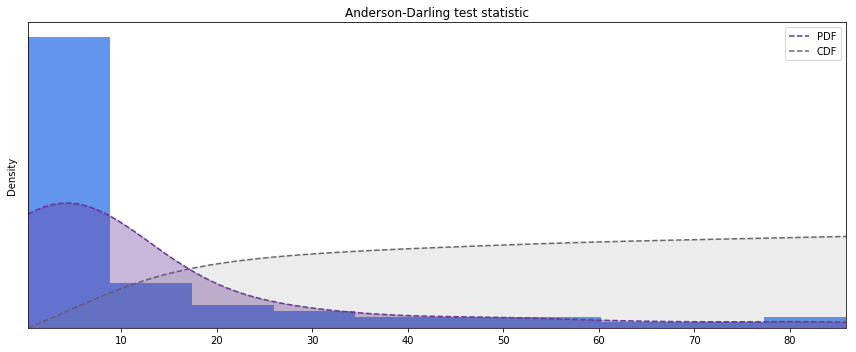

In [8]:
norm = pd.Series([anderson(df_numeric[c])[0] for c in df_numeric], index=df_numeric.columns)
maximum_finite = max(filter(lambda x: not x == np.infty, norm))
finite_norm = norm.apply(lambda x: min(maximum_finite, x))

plot_histogram(finite_norm, title="Anderson-Darling test statistic");

Based on this distribution, 20 seems like a good cut-off value for a list.

In [9]:
description.loc['anderson'] = finite_norm

high_anderson = description.loc['anderson'].where(lambda x: x > 20).dropna().sort_values(ascending=False)
high_anderson

BRAF_N          85.892736
AcetylH3K9_N    85.783742
DYRK1A_N        74.352495
pERK_N          66.770354
pELK_N          58.045646
Tau_N           52.473828
ITSN1_N         48.509978
SOD1_N          46.589849
RRP1_N          40.618962
BCL2_N          35.070336
H3AcK18_N       29.416407
H3MeK4_N        29.278540
ELK_N           26.198888
pPKCAB_N        25.716155
EGR1_N          24.663063
BAD_N           20.816607
Name: anderson, dtype: float64

There seems to be a significant overlap between variables with a high coefficient of variation, and variables that are highly non-normal.

If we create sets from the proteins above the cutoff level in each case, we can see which proteins are present in both sets.

In [10]:
high_anderson_and_cova = set(high_anderson.index) & set(high_cova.index)
print(high_anderson_and_cova)

{'BRAF_N', 'pELK_N', 'Tau_N', 'SOD1_N', 'pERK_N', 'H3AcK18_N', 'ITSN1_N', 'AcetylH3K9_N', 'DYRK1A_N', 'pPKCAB_N'}


That leaves ten variables that have been selected for through multiple mechanisms.  Let's go ahead and visualize them all at the same time.

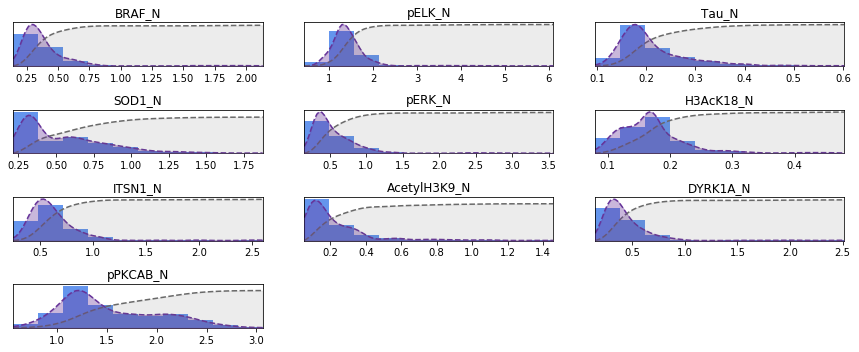

In [11]:
protein_data = [df[protein] for protein in high_anderson_and_cova]

plot_histogram(*protein_data, title=high_anderson_and_cova);

Other interesting metrics to look at include the skew and kurtosis of distributions.  Skew measures the symmetry of a distribution about its mean, while kurtosis measures the portion of the data in the tails of the distribution.

Skew and kurtosis can be combined into a nice scatter plot that tells you a lot about the structure of your data set.

In [12]:
skews = df_numeric.apply(lambda x: skew(x))
skews.name = "skew"
kurts = df_numeric.apply(lambda x: kurtosis(x))
kurts.name = "kurtosis"

proteins = pd.Series([i.split("_")[0] for i in kurts.index], index=kurts.index, name="protein")
sk_df = pd.concat([skews, kurts, proteins], axis=1)
fig = scatter_with_hover(sk_df, "skew", "kurtosis", name="skew_kurt", cols=["protein"])
show(fig, notebook_handle=True);

In all likelyhood, the normality tests have already picked up those outliers, but lets take a look at them just for completeness.

In [13]:
high_skew_kurt = sk_df.loc[((skews * kurts).abs() >= 5),["skew", "kurtosis"]]
high_skew_kurt

,skew,kurtosis
DYRK1A_N,4.356940,27.302549
ITSN1_N,3.622487,21.481122
pELK_N,3.994880,25.609647
pERK_N,3.835335,22.367986
BRAF_N,4.547660,28.176251
CDK5_N,2.481156,35.276894
AcetylH3K9_N,2.678724,8.917021
RRP1_N,3.998651,45.898794
Tau_N,1.864722,4.548578
GluR4_N,4.732316,62.253754


These proteins should be starting to get familiar by now.

### Identifying structure

In addition to looking for deviations, it is important to identify the latent structure in the data.  There are a number of techniques for accomplishing this.  Clustering is a good way to expose structure in the data.  Hierarchical clustering algorithms are good because you don't need to specify a cluster count.  Hierarchical clustering algorithms also gives your variables a partial order, which you can take advantage of.  My preferred form of clustering is a technique called HDBSCAN.  It takes the minimum cluster size as the only parameter, and it produces both discrete and hierarchical clustering.

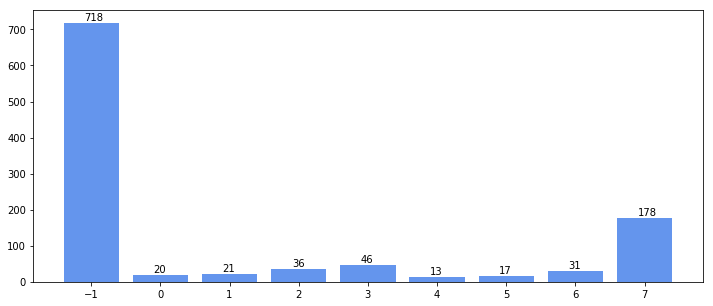

In [14]:
fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(ecdf_normalized_df)
base_sample_clusters = pd.Series(fit.labels_, index=ecdf_normalized_df.index)
counter_histogram(base_sample_clusters)

Note that the initial clustering produced a large number of unclustered samples (-1).  Ideally, there would be relatively few unclustered samples.  To try and get that number down, I'm going to try varying the data set used to cluster the samples.

On the plus side, the total number of different experimental conditions in the data set is eight, so the fact that eight clusters were detected is good.

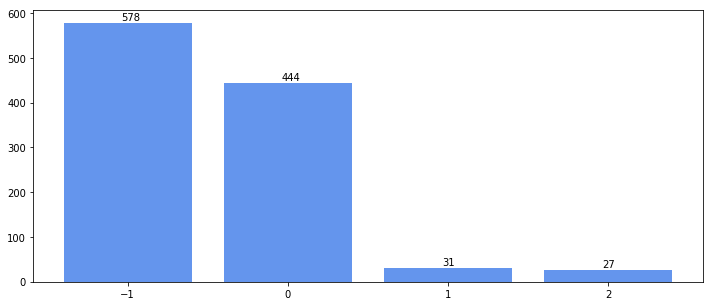

In [15]:
interesting_proteins = list(set(high_anderson.index) | set(high_cova.index) | set(high_skew_kurt.index))
interesting_df = ecdf_normalized_df[interesting_proteins]
fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(interesting_df)
interesting_sample_clusters = pd.Series(fit.labels_, index=interesting_df.index, name="cluster")

counter_histogram(interesting_sample_clusters)

While using only interesting proteins for clustering reduced the number of unlcustered points, the number of clusters is too small given our knowledge of the data.  Additionally, cluster 0 is larger than any known segment of the data set.  Let's take a look at the breakdown of that cluster to see what it's made of.

In [16]:
mask = interesting_sample_clusters == 0
groups = df[mask].join(interesting_sample_clusters).groupby(["Genotype", "Treatment", "Behavior"])
groups.count()[["cluster"]]

cluster
Genotype Treatment Behavior         
Control  Memantine C/S            34
                   S/C           103
         Saline    C/S            11
                   S/C            65
Ts65Dn   Memantine C/S            50
                   S/C            47
         Saline    C/S            48
                   S/C            86

That cluster seems to be weakly biased towards S/C mice, but overall it displays very poor separation of groups.

Another technique we can try to improve our ability to resolve the samples into a good clustering is to perform dimensionality reduction on the variables.  This effectively eliminates colinearity between the variables that might interfere with achieving good clustering results.  There are a number of dimensionality reduction techniques, but it's usually a good idea to start with principle component analysis (PCA) as it provides you with information on how much of the data's original variance is captured by each dimension.  This is handy because it lets you put an upper bound on the number of dimensions to specify for other techniques such as independent component analysis and autoencoders.

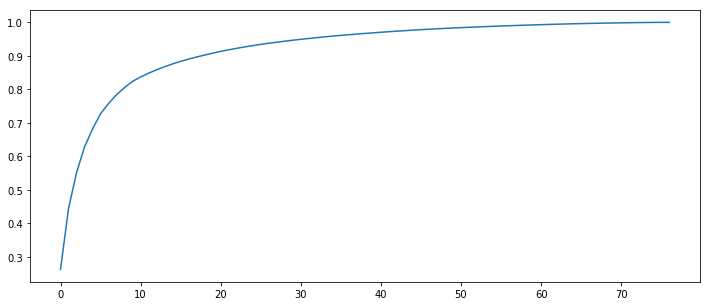

In [17]:
pc = PCA()
reduced_df = pd.DataFrame(pc.fit_transform(ecdf_normalized_df), index=ecdf_normalized_df)

fig, ax = plt.subplots()
total_var = np.sum(pc.explained_variance_)
cumulative_var = np.cumsum(pc.explained_variance_)
ax.plot(cumulative_var / total_var);

From this plot we can see that the sweet spot is near 10 components.  One thing to keep in mind is that PCA works best when your data distribution is multivariate normal.  Since we know from the distribution of the Anderson Darling test statistics that the data deviates strongly from normality, other methods of dimensionality reduction are likely to perform better than PCA.

Independent component analysis is a good technique to use with non-normal data.  Let's try it with 15 components and see what sort of results we get.

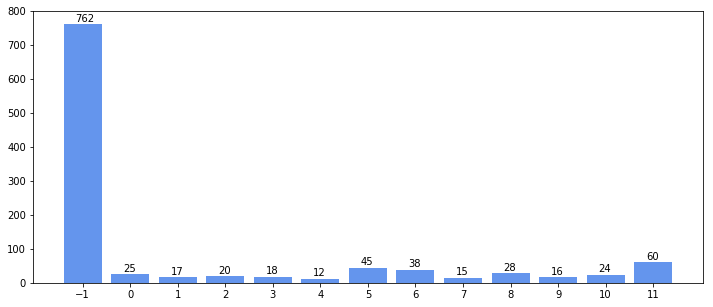

In [18]:
ic = FastICA(n_components=15)
reduced_df = pd.DataFrame(ic.fit_transform(ecdf_normalized_df), index=ecdf_normalized_df.index)

fit = hdbscan.HDBSCAN(min_cluster_size=12).fit(reduced_df)
reduced_sample_clusters = pd.Series(fit.labels_, index=interesting_df.index, name="cluster")

counter_histogram(reduced_sample_clusters)

Unfortunately, applying dimensionality reduction in this case didn't seem to help much.  It is possible that the results would be better with a different number of components, or different clustering parameters.  So far I've been guessing parameter values and intuitively evaluating the results.  This approach is time consuming and unlikely to produce optimal results.  What we need to do is perform a grid search over the parameter space to determine the optimal values.

In order to perform a grid search, I need to define an objective measure of the *quality* of a given clustering. In this specific case, there are several factors to consider.

The first is the number of resulting clusters.  Given that there are 8 different experimental conditions in the data set, it is reasonable to expect that there would be 8 clusters, but this is not necessarily the case.  Some experimental conditions may have little effect (producing fewer clusters), or there may be phenotypic variation in the mice within a given experimental condition (producing more clusters).  Thus, the solution should prefer clusterings with around 8 clusters, but that should be a loose constraint.  To model this prior belief about the number of clusters, I will scale the objective by the density of a gamma distribution with a mode of 8.

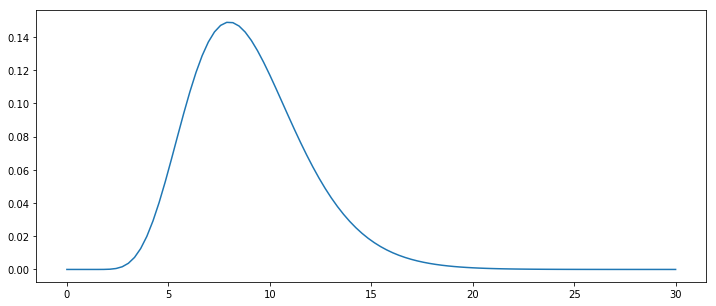

In [19]:
dist = gamma(8, 1)
X = np.linspace(0, 30, 100)
Y = [dist.pdf(x) for x in X]

fig, ax = plt.subplots()
ax.plot(X, Y);

After the number of clusters, the next important factor is the quality of the individual clusters.  Since we're trying to recover the experimental conditions from the data, the most obvious criterion is the entropy of the set of experimental conditions for the cluster.

Assuming that cluster entropy is the value that I want to minimize, I have to determine what exactly I'm going to take the entropy of.  The simplest solution is to take the entropy of all experimental conditions simultaneously.  The problem with this is that variance in one of the experimental conditions increases the entropy by the same amount as variance in all of them.  Intuitively, it is preferable if we calculate the entropy for each experimental condition separately, then add them together.

An additional point of consideration here is that the data set has multiple samples from the same organism.  Theoretically a good clustering should put samples from the same organism in the same cluster.  Since the experimental conditions do not vary from sample to sample for a given organism, this is partially captured by the entropy of the experimental conditions, but I'm going to specifically include it to try and produce the best clusters possible.

Finally, since each experimental condition has a roughly equivalent number of samples, I would prefer clusterings that evenly distribute samples among the various clusters.

In [20]:
clusters_prior = gamma(8, 1)

def ent(data):
    p_data = data.value_counts()/len(data)
    e = entropy(p_data)
    return e

def objective(df, labels):
    e = ent(labels)
    cluster_count_factor = clusters_prior.pdf(labels.max() + 1)
    clusters = df.join(labels).groupby("cluster")
    for (i, c) in clusters:
        e -= ent(c["Genotype"]) - ent(c["Treatment"]) - ent(c["Behavior"]) - ent(c["mouse_id"])
    return e * cluster_count_factor 

In [21]:
import tempfile

tmp_dir = tempfile.mkdtemp()

In [22]:
def search_parameters():
    for ndim in range(8, 20):
        ica = FastICA(n_components=ndim)
        df_ = pd.DataFrame(ica.fit_transform(ecdf_normalized_df), index=ecdf_normalized_df.index)
        for method in ["eom", "leaf"]:
            for min_samples in range(5,15):
                for min_cluster_size in range(15, 30):
                    try:
                        fit = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                                              cluster_selection_method=method, memory=tmp_dir).fit(df_)
                        clusters = pd.Series(fit.labels_, index=df.index, name="cluster")
                        yield [objective(df, clusters), ndim, method, min_samples, min_cluster_size]
                    except ValueError as err:
                        print("Computation error, ndim: %s, method: %s, min_samples: %s, min_cluster_size: %s" %
                             (ndim, method, min_samples, min_cluster_size))

results = list(search_parameters())                 
columns = ["objective", "ndim", "method", "min_samples", "min_cluster_size"]
results = pd.DataFrame(results, columns=columns)

Computation error, ndim: 18, method: leaf, min_samples: 13, min_cluster_size: 29
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 22
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 23
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 24
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 25
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 26
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 27
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 28
Computation error, ndim: 18, method: leaf, min_samples: 14, min_cluster_size: 29
Computation error, ndim: 19, method: leaf, min_samples: 13, min_cluster_size: 25
Computation error, ndim: 19, method: leaf, min_samples: 13, min_cluster_size: 26
Computation error, ndim: 19, method: leaf, min_samples: 13, min_cluster_size: 27
Computation error, ndim: 19,

In [23]:
results.sort_values("objective", ascending=False).head(n=20)

,objective,ndim,method,min_samples,min_cluster_size
1721,3.276155,13,leaf,9,26
1723,3.276155,13,leaf,9,28
1724,3.276155,13,leaf,9,29
1719,3.276155,13,leaf,9,24
1722,3.276155,13,leaf,9,27
1720,3.276155,13,leaf,9,25
1570,3.257672,13,eom,9,25
1574,3.257672,13,eom,9,29
1573,3.257672,13,eom,9,28
1572,3.257672,13,eom,9,27


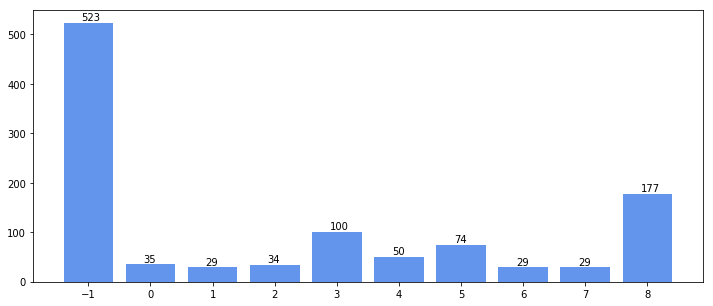

In [24]:
ic = FastICA(n_components=13)
reduced_df = pd.DataFrame(ic.fit_transform(ecdf_normalized_df), index=ecdf_normalized_df.index)

fit = hdbscan.HDBSCAN(min_cluster_size=28, cluster_selection_method='leaf', min_samples=9).fit(reduced_df)
reduced_sample_clusters = pd.Series(fit.labels_, index=interesting_df.index, name="cluster")

counter_histogram(reduced_sample_clusters)

This clustering is **much** better than the ones produced by manual exploration.

It is worth noting that ICA with 8 components seems to produce results that are nearly as good as the 13 component case.  Let's take a look at how proteins map into this latent feature space.

In [25]:
ic = FastICA(n_components=8)
ic.fit(ecdf_normalized_df)

component_df = pd.DataFrame(ic.components_.transpose(), index=ecdf_normalized_df.columns)

component_top_proteins = [pd.Series(c).index[:5] for c in component_df]
normalized_component_df = component_df.apply(lambda c: pd.Series(ECDF(c)(c), index=c.index))

fig = block_heatmap(normalized_component_df)
fig.x_range = Range1d(-0.5,7.5)
show(fig, notebook_handle=True);

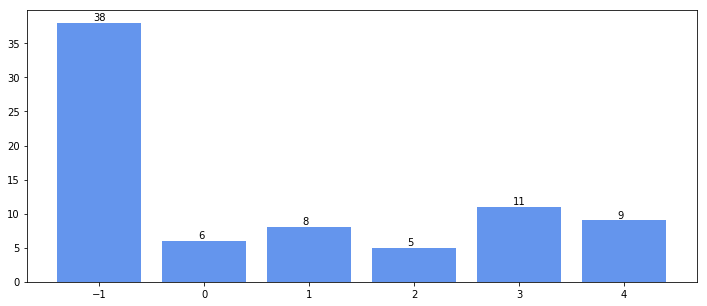

In [26]:
def reorder_rows(fit, df):
    clusters = fit.single_linkage_tree_.to_networkx()
    leaf_nodes = set([n for n in clusters.nodes()
                      if clusters.in_degree(n) != 0  and clusters.out_degree(n) == 0])
    index_order = {i: v for i, v in enumerate(df.index)}
    rows = [index_order[int(c)] for c in nx.topological_sort(clusters) if c in leaf_nodes]
    return df.loc[rows]

clustered_df = ecdf_normalized_df.assign(cluster=reduced_sample_clusters)
sorted_df = reorder_rows(fit, clustered_df).sort_values("cluster")
transpose_df = sorted_df.drop("cluster", 1).transpose()

t_fit = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_method='leaf').fit(transpose_df)

dimension_clusters = pd.Series(t_fit.labels_, index=transpose_df.index)

t_clustered_df = transpose_df.assign(cluster=dimension_clusters)
t_sorted_df = reorder_rows(t_fit, t_clustered_df).sort_values("cluster")

clustered_only = t_sorted_df[t_sorted_df["cluster"] >= 0]
counter_histogram(dimension_clusters)

Next we're going to visualize the distribution of the variables.  In order to do this we need to convert them from 1080 dimensions down to 2.  The best techniques to do this are multidimensional scaling and t-stochastic neighbor embedding.  Both are available as part of scikits-learn.

In [27]:
mds_fit = MDS().fit_transform(transpose_df)
mds_df = pd.DataFrame(mds_fit, index=proteins.index, columns=["x", "y"]).join(proteins)
fig = scatter_with_hover(mds_df, "x", "y")
show(fig, notebook_handle=True);

Unfortunately the latent structure of the data isn't very interesting in two dimensions.  It is still useful to know which proteins are central and which are peripheral, as this gives you an idea how early in the regulatory cascade they occur.

Let's take a look at the list of variables sorted by distance from the center of the distribution, along with their cluster.

In [28]:
d = pd.Series(np.sqrt(mds_df["x"] ** 2 + mds_df["y"] ** 2), index=mds_df.index, name="distance")

clustered_only.join(d).sort_values(["cluster", "distance"])[["distance", "cluster"]]

,distance,cluster
H3AcK18_N,10.147864,0
H3MeK4_N,10.410855,0
SNCA_N,10.464994,0
BAD_N,11.004156,0
BCL2_N,11.136682,0
EGR1_N,11.355165,0
TIAM1_N,2.517704,1
NR2B_N,4.157152,1
AMPKA_N,4.603190,1
RAPTOR_N,4.962855,1


Here clusters can be thought of as roughly representing biochemical regulatory pathways.  The proteins with a lower distance are likely to strongly influence activity proteins with a higher distance.

In [29]:
df_clustered = clustered_df["cluster"] >= 0
sorted_clustered = sorted_df["cluster"] >= 0
cols = ["Genotype", "Treatment", "Behavior"]
in_cluster = df[df_clustered]
cluster_conditions = sorted_df[sorted_clustered].loc[:, ["cluster"]]
cluster_conditions = cluster_conditions.join(in_cluster[cols])

group_cluster = cluster_conditions.groupby("cluster")

behavior_counts = [pd.Series(group["Behavior"].value_counts(), name="Cluster %s" % idx) 
                   for (idx, group) in group_cluster]
behavior_counts = pd.DataFrame(behavior_counts).fillna(0)

def count_mice(group):
    return len(set(i.split("_")[0] for i in group.index))

mouse_counts = [count_mice(group) for (idx, group) in group_cluster]
mice = pd.Series(mouse_counts, name="mice", index=behavior_counts.index)
behavior_counts.join(mice)

,C/S,S/C,mice
Cluster 0,35.0,0.0,3
Cluster 1,29.0,0.0,3
Cluster 2,34.0,0.0,3
Cluster 3,70.0,30.0,13
Cluster 4,50.0,0.0,5
Cluster 5,24.0,50.0,9
Cluster 6,0.0,29.0,4
Cluster 7,1.0,28.0,5
Cluster 8,0.0,177.0,18


That separation of condition by cluster appears pretty good.  The next step is to look at genotype and condition separation by cluster.

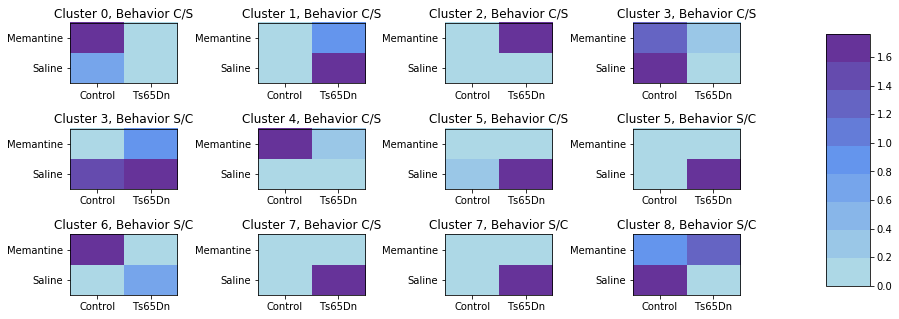

In [30]:
group_cluster_behavior = cluster_conditions.groupby(["cluster","Behavior"])

fig, axes = plt.subplots(3, int(np.ceil(len(group_cluster_behavior) / 3)))

colors = ["#ADD8E6", "#9AC7E7", "#88B6E9", "#76A5EB", "#6495ED", "#647CD8", "#6564C3", "#654BAE", "#663399"]

my_cmap = ListedColormap(colors, name='my_name')

for g, a in zip_longest(group_cluster_behavior, axes.flatten()):
    if g is None:
        a.axis("off")
        break
    ((idx, cond), group) = g
    x = [1 if l == "Ts65Dn" else 0 for l in group["Genotype"]]
    y = [1 if l == "Memantine" else 0 for l in group["Treatment"]]
    res = a.hist2d(x, y, bins=2, range=[[0, 1], [0, 1]], normed=True, cmap=my_cmap)[3]
    a.set_title("Cluster %s, Behavior %s" % (idx, cond))
    a.set_xticklabels(["Control", "Ts65Dn"])
    a.set_xticks([0.25, 0.75])
    a.set_yticklabels(["Saline", "Memantine"])
    a.set_yticks([0.25, 0.75])
    a.set_xlim(0, 1)
    a.set_ylim(0, 1)

fig.subplots_adjust(wspace=0.75, hspace=0.75)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(res, cax=cbar_ax);

That separation is excellent.  While not all samples have been clustered, those that have appear to fall into distinct groups.

Next let's look at how protein levels change depending on cluster membership.

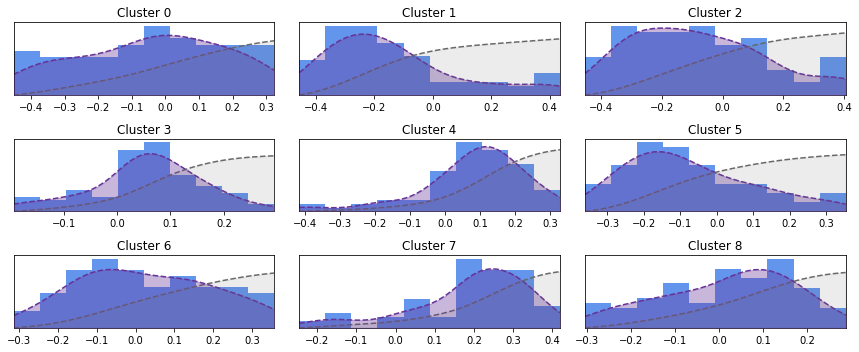

In [31]:
def diff_proteins(df):
    return df.apply(lambda x: x.mean() - 0.5).sort_values()

clusters = list(range(reduced_sample_clusters.max() + 1))
diffs = [diff_proteins(sorted_df.filter(like="_N", axis=1)[sorted_df["cluster"] == i]) for i in clusters]

titles = ["Cluster %s" % c for c in clusters]
plot_histogram(*diffs, title=titles);

# Identifying significant variables

In order to determine how significant a variable is to overall cluster assignment, we can look at the differences between the cluster mean percentiles and overall mean percentiles.  The larger the difference, the more significant that variable is to the clustering.  If we do this for all variables and put the results in a vector, the norm of that vector represents a measure of a variable's overall clustering importance.  We can use that measure to rank and filter variables.

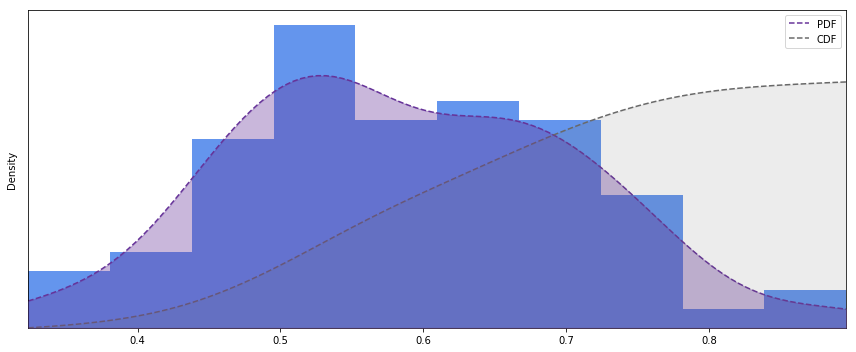

In [32]:
diffs_df = pd.DataFrame(diffs).transpose()
norms = pd.Series(np.sqrt(np.square(diffs_df).sum(axis=1)), name="norm")
plot_histogram(norms);

There aren't extreme outliers on the distribution of the norms.  The interesting part of this distribution is the outer tail.

In [33]:
high_clustered_norms = diffs_df.join(norms).sort_values('norm', ascending=False).head(n=10)
high_clustered_norms

,0,1,2,3,4,5,6,7,8,norm
pPKCG_N,-0.293995,-0.427490,0.012418,0.208231,-0.416944,0.353141,0.095243,0.398531,-0.154075,0.896038
pCAMKII_N,-0.383386,-0.395019,-0.308932,0.151306,-0.200296,-0.209922,0.357791,0.335792,0.132836,0.874048
P3525_N,-0.451614,-0.337165,-0.260458,0.096148,0.222722,0.235310,-0.119157,0.299425,-0.128714,0.787474
pP70S6_N,-0.176931,-0.457631,-0.119499,0.149111,-0.414889,0.176602,0.174393,0.299489,0.017279,0.775223
pERK_N,0.281190,0.435185,0.355692,0.079185,0.239537,-0.248286,-0.139208,0.030268,-0.211519,0.765049
RAPTOR_N,0.296138,-0.364623,-0.272549,0.068519,0.130815,-0.316617,0.237516,0.319700,0.043220,0.759917
pRSK_N,-0.079815,-0.427075,0.153540,0.236833,-0.325167,-0.020946,-0.061622,0.419636,-0.094947,0.750671
BRAF_N,0.233492,0.406960,0.404575,0.042667,0.117574,-0.207845,-0.294189,0.041443,-0.159285,0.745853
DYRK1A_N,0.262513,0.428097,0.402315,0.081111,0.128833,-0.153829,-0.207312,0.123180,-0.184003,0.743563
P38_N,-0.088175,-0.356801,-0.402723,0.037046,-0.004259,-0.230531,0.277331,0.209483,0.227992,0.724278


These proteins represent the largest differentiators between clusters.

Let's see how this list compares with the list that results from examining the norms of data grouped by class.

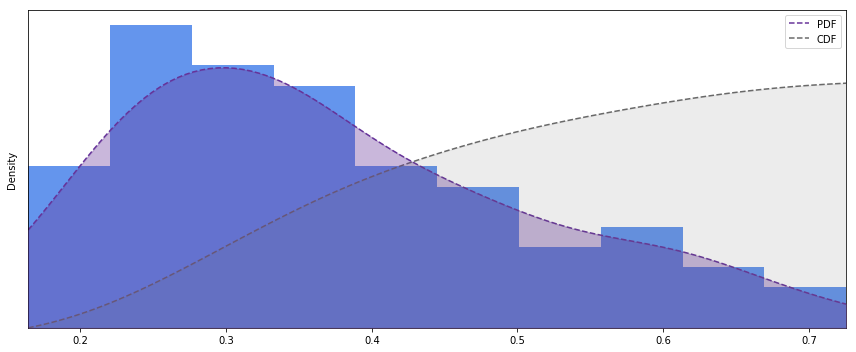

In [34]:
categorical_cols = ["Genotype", "Behavior", "Treatment"]
means = ecdf_normalized_df.join(df[categorical_cols]).groupby(categorical_cols).mean().apply(lambda c: c - 0.5)
t_means = means.transpose()
unclustered_norms = pd.Series(np.sqrt(np.square(t_means).sum(axis=1)), name="norm")

plot_histogram(unclustered_norms);

The upper tail of the distribution for norms here is about 0.55.  Let's take a look at those proteins.

In [35]:
high_unclustered_norms = t_means.join(unclustered_norms).sort_values("norm", ascending=False).head(n=10)
high_unclustered_norms

,"(Control, C/S, Memantine)","(Control, C/S, Saline)","(Control, S/C, Memantine)","(Control, S/C, Saline)","(Ts65Dn, C/S, Memantine)","(Ts65Dn, C/S, Saline)","(Ts65Dn, S/C, Memantine)","(Ts65Dn, S/C, Saline)",norm
SOD1_N,-0.213580,-0.243930,0.164827,0.318374,-0.299540,-0.276728,0.283429,0.214794,0.725548
pERK_N,0.234302,0.196379,-0.211340,-0.291584,0.317394,0.229506,-0.222339,-0.200144,0.682680
CaNA_N,0.188290,0.241927,-0.313506,-0.166955,0.270926,0.204638,-0.274472,-0.087757,0.646882
DYRK1A_N,0.173043,0.123649,-0.289340,-0.288519,0.336036,0.249127,-0.134259,-0.097730,0.644014
P38_N,-0.023623,-0.172888,0.228407,0.179657,-0.245082,-0.372143,0.254636,0.049321,0.617027
BRAF_N,0.170846,0.104794,-0.237389,-0.236351,0.341077,0.208519,-0.135357,-0.158683,0.596406
ARC_N,-0.024549,-0.194870,0.147833,0.252462,-0.283745,-0.211314,0.312490,-0.055261,0.591639
pS6_N,-0.024549,-0.194870,0.147833,0.252462,-0.283745,-0.211314,0.312490,-0.055261,0.591639
ITSN1_N,0.107512,0.090583,-0.309710,-0.280343,0.281564,0.266975,-0.013567,-0.057490,0.590186
Ubiquitin_N,-0.098907,-0.296872,0.276401,0.070720,-0.264588,-0.080988,0.296180,0.064040,0.589665


This list is different from  the clustered list because it isn't influenced by data separability. As a result, more general variation is incorporated.  The proteins only present here are likely to be important in multiple pathways.

Let's take a look at the similarities and differences in these groups.

In [36]:
s_clu_norms = set(high_clustered_norms.index)
s_unc_norms = set(high_unclustered_norms.index)

print("Both: " + ", ".join(g.split("_")[0] for g in s_clu_norms & s_unc_norms))
print("Clustered only: " + ", ".join(n.split("_")[0] for n in s_clu_norms if n not in s_unc_norms))
print("Unclustered only: " + ", ".join(n.split("_")[0] for n in s_unc_norms if n not in s_clu_norms))

Both: pERK, BRAF, P38, DYRK1A
Clustered only: pP70S6, pRSK, P3525, RAPTOR, pCAMKII, pPKCG
Unclustered only: SOD1, ARC, pS6, ITSN1, CaNA, Ubiquitin


The regulatory cascade is probably driven by proteins present in both groups.  Proteins present only in the unclustered group probably exert a weak, non-specific regulatory influence on the cell.  Proteins present in the clustered group only probably play a role in controlling the magnitude of the effect.

In [37]:
categorical_columns = ["Genotype", "Treatment", "Behavior"]
small_df = t_sorted_df.drop("cluster", 1).loc[:,df_clustered]
conditions = df.loc[:, categorical_columns]

In [38]:
def only_samples_where(df, genotype=None, treatment=None, behavior=None):
    genotype = genotype or set()
    treatment = treatment or set()
    behavior = behavior or set()
    df = df.transpose().join(conditions)
    
    def mask(value=False):
        return pd.Series([value for _ in df.index], dtype=bool, index=df.index)
    
    m = mask(True)
    
    if genotype:
        genotype_mask = mask(False)
        if "Control" in genotype:
            genotype_mask |= df["Genotype"] == "Control"
        if "Ts65Dn" in genotype:
            genotype_mask |= df["Genotype"] == "Ts65Dn"
        m &= genotype_mask
    
    if treatment:
        treatment_mask = mask(False)
        if "Memantine" in treatment:
            treatment_mask |= df["Treatment"] == "Memantine"
        if "Saline" in treatment:
            treatment_mask |= df["Treatment"] == "Saline"
        m &= treatment_mask
        
    if behavior:
        behavior_mask = mask(False)
        if "C/S" in behavior:
            behavior_mask |= df["Behavior"] == "C/S"
        if "S/C" in behavior:
            behavior_mask |= df["Behavior"] == "S/C"
        m &= behavior_mask
        
        return df[m].drop(categorical_columns, axis=1).transpose()

In [39]:
def filtered_heatmap(genotype, treatment, behavior):
    filtered_df = only_samples_where(small_df, genotype=genotype, treatment=treatment, behavior=behavior)
    fig = block_heatmap(filtered_df, width=875)
    show(fig, notebook_handle=True)

genotype_opts = {"All": "Control Ts65Dn", "Control": "Control", "Ts65Dn": "Ts65Dn"}
treatment_opts = {"All": "Memantine Saline", "Saline": "Saline", "Memantine": "Memantine"}
behavior_opts = {"All": "C/S S/C", "Learning": "C/S", "No learning": "S/C"}
interact(filtered_heatmap, genotype=genotype_opts, treatment=treatment_opts, behavior=behavior_opts);

Widget Javascript not detected.  It may not be installed or enabled properly.


This beast of a plot shows patterns of activity for every protein in the database.